# Multilayer Perceptron (MLP)

Classification of beans in species using MLP (Sklearn and Keras) based on most important features according to the info provided by the optimal random forest.

In [51]:
# Installing dependencies
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import  GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Input
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [57]:
# Fetching imbalanced datasets
with open('X_train', 'rb') as file: X_train = pickle.load(file)
with open('y_train', 'rb') as file: y_train = pickle.load(file)
with open('X_test' , 'rb') as file: X_test  = pickle.load(file)
with open('y_test' , 'rb') as file: y_test  = pickle.load(file)

In [58]:
# Standardizing the feature values of the imbalanced dataset and encoding the labels as integers
scaler = StandardScaler()
features_names = X_train.columns
X = scaler.fit_transform(pd.concat([X_train, X_test]))
X_train, X_test = X[:len(X_train)], X[len(X_train):]
y, labels = pd.factorize(pd.concat([y_train, y_test])['Class'])
y_train, y_test = y[:len(y_train)], y[len(X_train):]

In [8]:
# Sorting features by importance provided by the optimal random forest
with open('best_rf_clf.pkl', 'rb') as file: best_rf_clf = pickle.load(file)
features_dict = dict(enumerate(best_rf_clf.feature_importances_))
features_list = sorted(features_dict.items(), key = lambda item: item[1], reverse = True)
features_list

[(2, 0.3142879027641842),
 (3, 0.1648580501373519),
 (12, 0.13808776116926594),
 (14, 0.08173824405512492),
 (11, 0.08022147851974754),
 (1, 0.05958046565876466),
 (10, 0.047421763420313255),
 (15, 0.02583965423737132),
 (6, 0.01612903611346848),
 (7, 0.015260908597228853),
 (0, 0.014314709326667466),
 (9, 0.012900469224532364),
 (8, 0.00849707138253093),
 (13, 0.008284226719571824),
 (4, 0.007139114650114524),
 (5, 0.00543914402376185)]

### MLP with imbalanced classes

In [9]:
# Defining the hyperparameter distribution for random search
param_grid = {'epochs': [10, 20, 50],
              'optimizer': ['adam', 'sgd'],
              'batch_size': [32, 64, 128]}

In [15]:
# Optimizing the hyperparameters
    
def create_model(optimizer='adam', dimension=dimension):
    """Defining a MLP with three hidden layers"""
    model = Sequential([Input(shape=(dimension,)),
                        Dense(64, activation='relu'),
                        Dense(32, activation='relu'),
                        Dense(16, activation='relu'),
                        Dense(7, activation='softmax')])  # Output layer size matches the number of classes (7)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def calculate_metrics(y_test, y_pred):
    """Calculating scoring metrics"""
    precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 4)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    return [precision, recall, f1, accuracy]
    
features_train = []
results_df1 = pd.DataFrame(columns = ['batch_size', 'epochs', 'optimizer'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature added'])

with tqdm(total=len(features_list)) as progress_bar:
    for feature_index, feature_importance in features_list: # Feeding new features by importance in each interation
    
        # Creating a NN for a given number of features
        features_train.append(feature_index)
        dimension = len(features_train)
        mlp_clf = KerasClassifier(model=create_model(dimension=dimension), verbose=0, random_state=42)
        grid_search = GridSearchCV(estimator=mlp_clf, param_grid=param_grid, n_jobs=-1, cv=3)

        # Optimizing the hyperparameters for a given number of features
        X_train_temp = pd.DataFrame(X_train).iloc[:,features_train].to_numpy()
        grid_search.fit(X_train_temp, y_train, validation_split=.1)  # Set to 0.1 to ensure at least 10000 features for training data
        results_df1.loc[len(features_train)] = grid_search.best_params_
    
        # Evaluating the model for a given number of features
        best_clf = grid_search.best_estimator_
        y_pred = best_clf.predict(pd.DataFrame(X_test).iloc[:,features_train].to_numpy())
        results_df2.loc[len(features_train)] = calculate_metrics(y_test, y_pred) + [features_names[feature_index]]
        progress_bar.update(1)

results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

  0%|          | 0/16 [00:00<?, ?it/s]

/home/students/jchinchilla/miniforge3/envs/matrix/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/students/jchinchilla/miniforge3/envs/matrix/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/students/jchinchilla/miniforge3/envs/matrix/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/students/jchinchilla/miniforge3/envs/matrix/lib/python3.12/si

,batch_size,epochs,optimizer,Precision,Recall,F1 score,Accuracy,Feature added
1,32,10,adam,0.5051,0.6136,0.5369,0.6136,MajorAxisLength
2,128,20,adam,0.8776,0.8767,0.8758,0.8767,MinorAxisLength
3,128,50,adam,0.8819,0.8804,0.8800,0.8804,ShapeFactor1
4,128,20,adam,0.8789,0.8787,0.8781,0.8787,ShapeFactor3
5,128,20,adam,0.8795,0.8789,0.8784,0.8789,Compactness
6,64,50,adam,0.9139,0.9141,0.9135,0.9141,Perimeter
7,32,50,adam,0.9174,0.9166,0.9162,0.9166,Roundness
8,128,50,adam,0.9266,0.9262,0.9263,0.9262,ShapeFactor4
9,32,50,adam,0.9217,0.9207,0.9207,0.9207,ConvexArea
10,32,50,adam,0.9229,0.9220,0.9219,0.9220,EquivDiameter


This model considers a wider range of features to obtain the highest possible metrics as it can learn complex patterns and interactions between features, even when some features are not highly informative (highly correlated each other). The ability of MLP to effectively use all features without losing so much performance may be due to its capacity to capture and model non-linear relationships in the data, which simpler models might not handle as well (sensitive to dimensionality). Let's try to create new models eliminating features reducing the metric scores ('ShapeFactor3', 'ConvexArea'), and including or not the features after the eliminated ones that are incrementing again the metric scores, but not higher than the previous best state ('Compactness', 'EquivDiameter', 'Area').

In [18]:
# Evaluating the model performance with 'MajorAxisLength', 'MinorAxisLength', 'ShapeFactor1', 'Perimeter', 'Roundness', 'ShapeFactor4', 'Solidity', 'Compactness', 'EquivDiameter', and 'Area' features
results_df1 = pd.DataFrame(columns = ['batch_size', 'epochs', 'optimizer'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature extra'])
features_important = ['MajorAxisLength', 'MinorAxisLength', 'ShapeFactor1', 'Perimeter', 'Roundness', 'ShapeFactor4', 'Solidity']
features_extra = [[], ['Compactness'], ['EquivDiameter'], ['Area'], ['Compactness', 'EquivDiameter'], ['Compactness', 'Area'], ['EquivDiameter', 'Area'], ['Compactness', 'EquivDiameter', 'Area']]

with tqdm(total=len(features_extra)) as progress_bar:
    for i, feature in enumerate(features_extra):

        # Creating a NN for a given number of features
        features_selected = features_important + feature
        dimension = len(features_selected)
        mlp_clf = KerasClassifier(model=create_model(dimension=dimension), verbose=0, random_state=42)
        grid_search = GridSearchCV(estimator=mlp_clf, param_grid=param_grid, n_jobs=-1, cv=3)
    
        # Optimizing the hyperparameters for a given number of features
        X_train_temp = pd.DataFrame(X_train, columns=features_names).loc[:,features_selected].to_numpy()
        grid_search.fit(X_train_temp, y_train, validation_split=.1)  # Set to 0.1 to ensure at least 10000 features for training data
        results_df1.loc[i] = grid_search.best_params_
        
         # Evaluating the model for a given number of features
        best_clf = grid_search.best_estimator_
        y_pred = best_clf.predict(pd.DataFrame(X_test, columns=features_names).loc[:,features_selected].to_numpy())
        results_df2.loc[i] = calculate_metrics(y_test, y_pred) + [feature]
        progress_bar.update(1)
    
results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

  0%|          | 0/8 [00:00<?, ?it/s]

/home/students/jchinchilla/miniforge3/envs/matrix/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-06-21 22:28:20.865387: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:28:20.865387: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:28:20.865460: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:28:20.865546: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 22:28:20.865681: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your 

,batch_size,epochs,optimizer,Precision,Recall,F1 score,Accuracy,Feature extra
0,128,50,adam,0.9241,0.9237,0.9238,0.9237,[]
1,32,50,adam,0.9260,0.9254,0.9253,0.9254,[Compactness]
2,128,50,adam,0.9250,0.9244,0.9246,0.9244,[EquivDiameter]
3,128,50,adam,0.9251,0.9247,0.9248,0.9247,[Area]
4,128,50,adam,0.9253,0.9247,0.9249,0.9247,"[Compactness, EquivDiameter]"
5,128,50,adam,0.9266,0.9262,0.9263,0.9262,"[Compactness, Area]"
6,128,50,adam,0.9265,0.9259,0.9261,0.9259,"[EquivDiameter, Area]"
7,128,50,adam,0.9250,0.9244,0.9246,0.9244,"[Compactness, EquivDiameter, Area]"


The model acquires the best performance as before without 'ShapeFactor3', 'ConvexArea', and now 'EquivDiameter'.

In [25]:
# Creating and evaluating the optimal MLP entirely and by classes
features_selected = ['MajorAxisLength', 'MinorAxisLength', 'ShapeFactor1', 'Perimeter', 'Roundness', 'ShapeFactor4', 'Solidity', 'Compactness', 'Area']
dimension = len(features_selected)
best_clf = KerasClassifier(model=create_model(optimizer='adam', dimension=dimension), verbose=1, random_state=42, batch_size=128)
X_train_temp = pd.DataFrame(X_train, columns=features_names).loc[:,features_selected].to_numpy()
best_clf.fit(X_train_temp, y_train, validation_split=.1, batch_size=128, epochs=50)  # Set to 0.1 to ensure at least 10000 features for training data
y_pred = best_clf.predict(pd.DataFrame(X_test, columns=features_names).loc[:,features_selected].to_numpy())
print(classification_report(y_test, y_pred, target_names=labels))

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4142 - loss: 1.6818 - val_accuracy: 0.7468 - val_loss: 0.9810
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7612 - loss: 0.8486 - val_accuracy: 0.8492 - val_loss: 0.4373
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8675 - loss: 0.4157 - val_accuracy: 0.9124 - val_loss: 0.2735
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9099 - loss: 0.2811 - val_accuracy: 0.9209 - val_loss: 0.2358
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9148 - loss: 0.2455 - val_accuracy: 0.9230 - val_loss: 0.2251
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9187 - loss: 0.2326 - val_accuracy: 0.9198 - val_loss: 0.2205
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9195 - loss: 0.2259 - val_accuracy: 0.9219 - val_loss: 0.2181
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9197 - loss: 0.2213 - val_accuracy: 0.9241 - val_loss:

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_136 (Dense)               │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,103 (39.47 KB)

 Trainable params: 3,367 (13.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,736 (26.32 KB)

<Axes: >

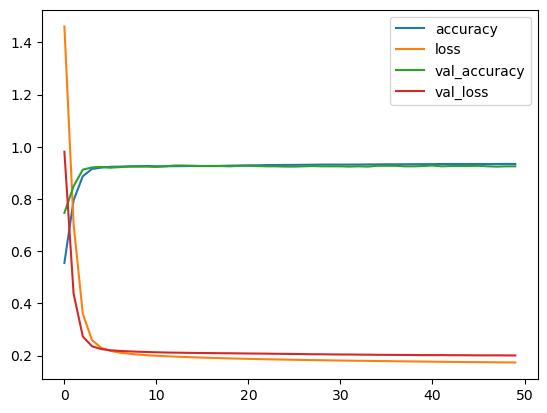

In [26]:
# Summary of the MLP structure, loggers and callbacks
best_clf.model_.summary()
pd.DataFrame(best_clf.history_).plot()

Overfitting not observed in this case as the training data.

### MLP with balanced classes

In [27]:
# Defining the hyperparameter distribution for random search
param_grid = {'mlp__epochs': [10, 20, 50],
              'mlp__optimizer': ['adam', 'sgd'],
              'mlp__batch_size': [32, 64, 128]}

In [35]:
# Optimizing the hyperparameters
features_train = []
results_df1 = pd.DataFrame(columns = ['mlp__batch_size', 'mlp__epochs', 'mlp__optimizer'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature added'])
smote = SMOTE(random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

with tqdm(total=len(features_list)) as progress_bar:
    for feature_index, feature_importance in features_list: # Feeding new features by importance in each interation

        # Creating a NN for a given number of features
        features_train.append(feature_index)
        dimension = len(features_train)
        mlp_clf = KerasClassifier(model=create_model(dimension=dimension), verbose=0, random_state=42)
        pipeline = Pipeline([('smote', SMOTE()), ('mlp', mlp_clf)])
        grid_search_balanced = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=kf, scoring='f1_weighted')
        
        # Optimizing the hyperparameters for a given number of features
        X_train_temp = pd.DataFrame(X_train).iloc[:,features_train].to_numpy()
        grid_search_balanced.fit(X_train_temp, y_train, mlp__validation_split=.1)  # Set to 0.1 to ensure at least 10000 features for training data
        results_df1.loc[len(features_train)] = grid_search_balanced.best_params_
    
        # Evaluating the model for a given number of features
        best_clf_balanced = grid_search_balanced.best_estimator_
        y_pred_balanced = best_clf_balanced.predict(pd.DataFrame(X_test).iloc[:,features_train].to_numpy())
        results_df2.loc[len(features_train)] = calculate_metrics(y_test, y_pred_balanced) + [features_names[feature_index]]
        progress_bar.update(1)

results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

  0%|          | 0/16 [00:00<?, ?it/s]

/home/students/jchinchilla/miniforge3/envs/matrix/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/students/jchinchilla/miniforge3/envs/matrix/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/students/jchinchilla/miniforge3/envs/matrix/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/students/jchinchilla/miniforge3/envs/matrix/lib/python3.12/si

,mlp__batch_size,mlp__epochs,mlp__optimizer,Precision,Recall,F1 score,Accuracy,Feature added
1,128,20,sgd,0.6010,0.5203,0.4886,0.5203,MajorAxisLength
2,64,20,sgd,0.8706,0.8654,0.8663,0.8654,MinorAxisLength
3,64,50,sgd,0.8817,0.8760,0.8764,0.8760,ShapeFactor1
4,64,50,sgd,0.8772,0.8730,0.8735,0.8730,ShapeFactor3
5,64,50,sgd,0.8763,0.8703,0.8713,0.8703,Compactness
6,64,50,adam,0.9077,0.9045,0.9048,0.9045,Perimeter
7,32,50,sgd,0.9140,0.9124,0.9125,0.9124,Roundness
8,32,20,sgd,0.9205,0.9173,0.9176,0.9173,ShapeFactor4
9,64,20,sgd,0.9222,0.9195,0.9200,0.9195,ConvexArea
10,32,10,adam,0.9208,0.9175,0.9178,0.9175,EquivDiameter


In this case the model uses all the features, except the least important ('Eccentricity'), to reach the best performance. However, metric scores are not better than those obtained on the model trained with imbalanced data.

In [ ]:
# Evaluating the model performance with 'MajorAxisLength', 'MinorAxisLength', 'ShapeFactor1', 'Perimeter', 'Roundness', 'ShapeFactor4', 'Solidity', 'Compactness', 'EquivDiameter', and 'Area' features
results_df1 = pd.DataFrame(columns = ['batch_size', 'epochs', 'optimizer'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature extra'])
features_important = ['MajorAxisLength', 'MinorAxisLength', 'ShapeFactor1', 'Perimeter', 'Roundness', 'ShapeFactor4', 'Solidity']
features_extra = [[], ['Compactness'], ['EquivDiameter'], ['Area'], ['Compactness', 'EquivDiameter'], ['Compactness', 'Area'], ['EquivDiameter', 'Area'], ['Compactness', 'EquivDiameter', 'Area']]
smote = SMOTE(random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

with tqdm(total=len(features_extra)) as progress_bar:
    for i, feature in enumerate(features_extra):

        # Creating a NN for a given number of features
        features_selected = features_important + feature
        dimension = len(features_selected)
        mlp_clf = KerasClassifier(model=create_model(dimension=dimension), verbose=0, random_state=42)
        pipeline = Pipeline([('smote', SMOTE()), ('mlp', mlp_clf)])
        grid_search_balanced = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1_weighted')
    
        # Optimizing the hyperparameters for a given number of features
        X_train_temp = pd.DataFrame(X_train, columns=features_names).loc[:,features_selected].to_numpy()
        grid_search_balanced.fit(X_train_temp, y_train, validation_split=.1)  # Set to 0.1 to ensure at least 10000 features for training data
        results_df1.loc[i] = grid_search_balanced.best_params_
        
         # Evaluating the model for a given number of features
        best_clf_balanced = grid_search_balanced.best_estimator_
        y_pred_balanced = best_clf_balanced.predict(pd.DataFrame(X_test, columns=features_names).loc[:,features_selected].to_numpy())
        results_df2.loc[i] = calculate_metrics(y_test, y_pred_balanced) + [feature]
        progress_bar.update(1)
    
results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

In [53]:
dimension

15

In [60]:
# Creating and evaluating the optimal MLP entirely and by classes
features_selected = list(features_names)
features_selected.remove('Eccentricity')
dimension = len(features_selected)
best_clf_balanced = KerasClassifier(model=create_model(optimizer='sgd', dimension=dimension), verbose=1, random_state=42, batch_size=64)
X_train_temp = pd.DataFrame(X_train, columns=features_names).loc[:,features_selected].to_numpy()
X_train_temp, X_val, y_train_temp, y_val = train_test_split(X_train_temp, y_train, test_size=0.25, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_temp, y_train_temp)
best_clf_balanced.fit(X_train_balanced, y_train_balanced, validation_data=(X_val, y_val), batch_size=64, epochs=50)
y_pred_balanced = best_clf_balanced.predict(pd.DataFrame(X_test, columns=features_names).loc[:,features_selected].to_numpy())
print(classification_report(y_test, y_pred_balanced, target_names=labels))

Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3013 - loss: 1.6837 - val_accuracy: 0.7000 - val_loss: 1.3107
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8052 - loss: 0.9654 - val_accuracy: 0.8338 - val_loss: 0.7241
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8827 - loss: 0.5186 - val_accuracy: 0.8726 - val_loss: 0.4657
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9085 - loss: 0.3477 - val_accuracy: 0.8945 - val_loss: 0.3676
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9239 - loss: 0.2786 - val_accuracy: 0.9034 - val_loss: 0.3204
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9286 - loss: 0.2445 - val_accuracy: 0.9046 - val_loss: 0.2933
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9317 - loss: 0.2242 - val_accuracy: 0.9076 - val_loss: 0.2754
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9328 - loss: 0.2104 - val_accuracy: 0.

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_256 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,753 (14.66 KB)

 Trainable params: 3,751 (14.65 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

<Axes: >

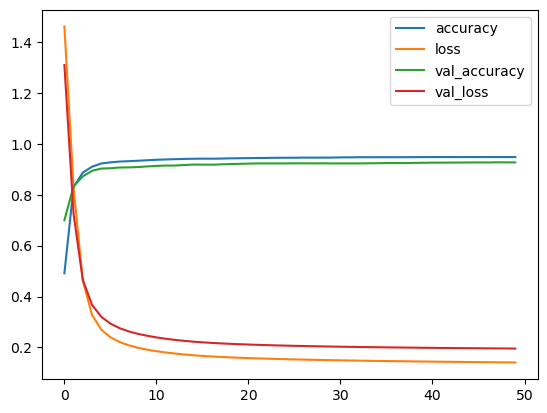

In [61]:
# Summary of the MLP structure, optimal hyperparameters, loggers and callbacks
best_clf_balanced.model_.summary()
pd.DataFrame(best_clf_balanced.history_).plot()

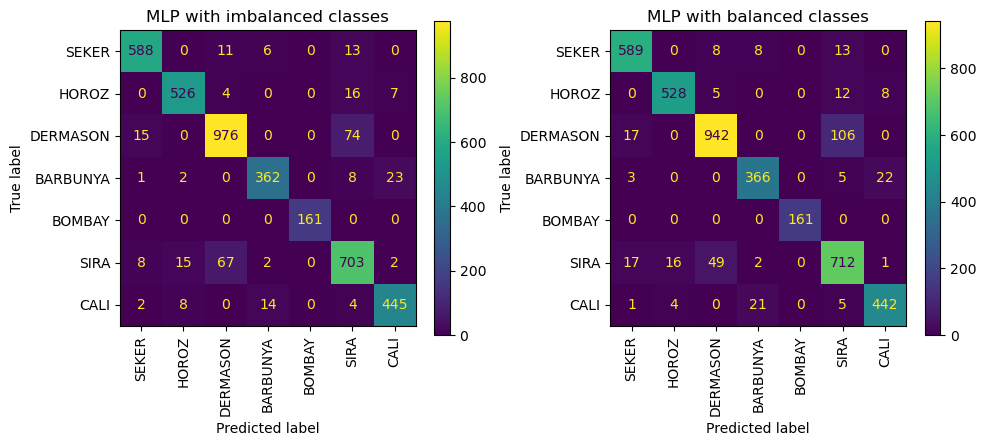

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plotting confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 16))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=axes[0], colorbar = False)
axes[0].set_title('MLP with imbalanced classes')
axes[0].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[0], shrink=0.2)

cm = confusion_matrix(y_test, y_pred_balanced)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=axes[1], colorbar = False)
axes[1].set_title('MLP with balanced classes')
axes[1].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[1], shrink=0.2)

plt.tight_layout()
plt.show()

In [65]:
# Saving optimal random forest with balanced classes
with open('best_mlp_clf.pkl', 'wb') as file:
    pickle.dump(best_clf, file)